# Welcome to Colab!

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from google.colab import files

def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show(img_bgr, title="", figsize=(10,7)):
    plt.figure(figsize=figsize)
    plt.imshow(bgr_to_rgb(img_bgr))
    plt.title(title)
    plt.axis("off")
    plt.show()

def ensure_list(x):
    return x if isinstance(x, list) else [x]

def draw_label_box(img, x, y, w, h, lines, box_color=(0,255,0)):
    out = img.copy()
    cv2.rectangle(out, (x, y), (x + w, y + h), box_color, 2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fs = 0.55
    th = 2
    pad = 6
    line_h = int(18 * fs) + 10

    text_w = 0
    for line in lines:
        (tw, _), _ = cv2.getTextSize(line, font, fs, th)
        text_w = max(text_w, tw)

    panel_w = text_w + 2 * pad
    panel_h = line_h * len(lines) + pad

    px = x
    py = y - panel_h - 5
    if py < 0:
        py = y + h + 5

    px = max(0, min(px, out.shape[1] - panel_w - 1))
    py = max(0, min(py, out.shape[0] - panel_h - 1))

    cv2.rectangle(out, (px, py), (px + panel_w, py + panel_h), (0, 0, 0), -1)
    cv2.rectangle(out, (px, py), (px + panel_w, py + panel_h), box_color, 2)

    for i, line in enumerate(lines):
        ty = py + pad + (i + 1) * line_h - 10
        cv2.putText(out, line, (px + pad, ty), font, fs, box_color, th, cv2.LINE_AA)

    return out

def clamp01(x):
    return float(max(0.0, min(1.0, x)))


Saving four-different-emotions-same-bearded-260nw-329282135.webp to four-different-emotions-same-bearded-260nw-329282135 (2).webp
Faces returned: 4

Face 1 expanded scores (top 6):
[('happy', 0.963), ('neutral', 0.037), ('surprise', 0.0), ('sad', 0.0), ('fear', 0.0), ('angry', 0.0)]

Face 2 expanded scores (top 6):
[('angry', 0.752), ('neutral', 0.128), ('depressed*', 0.087), ('sad', 0.06), ('fear', 0.055), ('confused*', 0.047)]

Face 3 expanded scores (top 6):
[('neutral', 0.615), ('angry', 0.375), ('depressed*', 0.252), ('confused*', 0.123), ('sad', 0.01), ('happy', 0.0)]

Face 4 expanded scores (top 6):
[('happy', 0.711), ('disgust', 0.236), ('angry', 0.028), ('fear', 0.021), ('neutral', 0.003), ('sad', 0.003)]


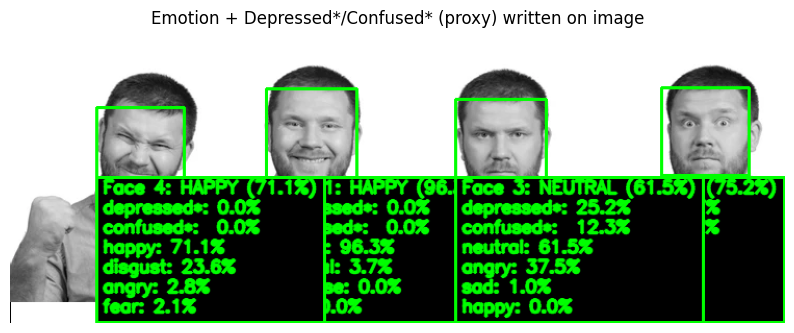

In [48]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("Could not read image. Upload a JPG/PNG.")

# Run DeepFace
res = DeepFace.analyze(
    img_path=img_path,
    actions=["emotion"],
    detector_backend="opencv",     # try "retinaface" for better face detection (slower)
    enforce_detection=False
)

faces = ensure_list(res)
print("Faces returned:", len(faces))

out = img_bgr.copy()

for i, r in enumerate(faces, start=1):
    region = r.get("region") or {}
    x = int(region.get("x", 0))
    y = int(region.get("y", 0))
    w = int(region.get("w", 0))
    h = int(region.get("h", 0))

    scores_pct = r.get("emotion", {}) or {}   # DeepFace returns % values (0..100)
    # Convert to 0..1 for easier math
    s = {k: float(v)/100.0 for k, v in scores_pct.items()}

    # Base 7 emotions (ensure keys exist)
    angry    = s.get("angry", 0.0)
    disgust  = s.get("disgust", 0.0)
    fear     = s.get("fear", 0.0)
    happy    = s.get("happy", 0.0)
    sad      = s.get("sad", 0.0)
    surprise = s.get("surprise", 0.0)
    neutral  = s.get("neutral", 0.0)

    # --- Add extra labels (PROXY/HEURISTIC) ---
    # Depressed proxy: high sad + neutral, low happy
    depressed = clamp01(0.60 * sad + 0.40 * neutral - 0.30 * happy)

    # Confused proxy: uncertainty-like mixture; surprise/fear + some neutral, penalize strong happy
    confused = clamp01(0.45 * surprise + 0.35 * fear + 0.20 * neutral - 0.20 * happy)

    # Build an expanded score dict (for ranking)
    expanded = {
        "angry": angry, "disgust": disgust, "fear": fear, "happy": happy,
        "sad": sad, "surprise": surprise, "neutral": neutral,
        "depressed*": depressed, "confused*": confused
    }

    # Dominant among expanded (optional)
    dominant = max(expanded.items(), key=lambda kv: kv[1])[0]
    dom_score = expanded[dominant]

    ordered = sorted(expanded.items(), key=lambda kv: kv[1], reverse=True)

    # Lines to write on the image
    lines = [
        f"Face {i}: {dominant.upper()} ({dom_score*100:.1f}%)",
        f"depressed*: {depressed*100:.1f}%",
        f"confused*:  {confused*100:.1f}%"
    ]
    # Add top-4 base emotions (excluding the * ones)
    base_only = [(k,v) for k,v in ordered if not k.endswith("*")]
    for k, v in base_only[:4]:
        lines.append(f"{k}: {v*100:.1f}%")

    if w > 0 and h > 0:
        out = draw_label_box(out, x, y, w, h, lines, box_color=(0,255,0))
    else:
        cv2.putText(out, f"Face {i}: {dominant} ({dom_score*100:.1f}%)",
                    (20, 40*i), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    print(f"\nFace {i} expanded scores (top 6):")
    print([(k, round(v, 3)) for k, v in ordered[:6]])

show(out, "Emotion + Depressed*/Confused* (proxy) written on image")


In [35]:
out_path = "emotion_deepface_result.jpg"
cv2.imwrite(out_path, out)
files.download(out_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>